In [1]:
import time
import math
import decimal
from pandas import DataFrame
from decimal import Decimal as dec
import seaborn as sns
import numpy as np
from numpy import random as np_rnd
from scipy.stats.distributions import norm
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from IPython.display import Latex

%matplotlib notebook

### Setup
At first, generate some random values

In [23]:
EPSILON = 1e-3
GRADIENT_STEP = 10 * EPSILON

alpha, beta = rnd.uniform(0, 1), rnd.uniform(0, 1)

X = [k / 100 for k in range(0, 101)]
delta = norm(loc=0, scale=1).rvs(size=101)
Y = [alpha * x_k + beta + delta_k for x_k, delta_k in zip(X, delta)]

Then visualize the generated noise

<IPython.core.display.Javascript object>


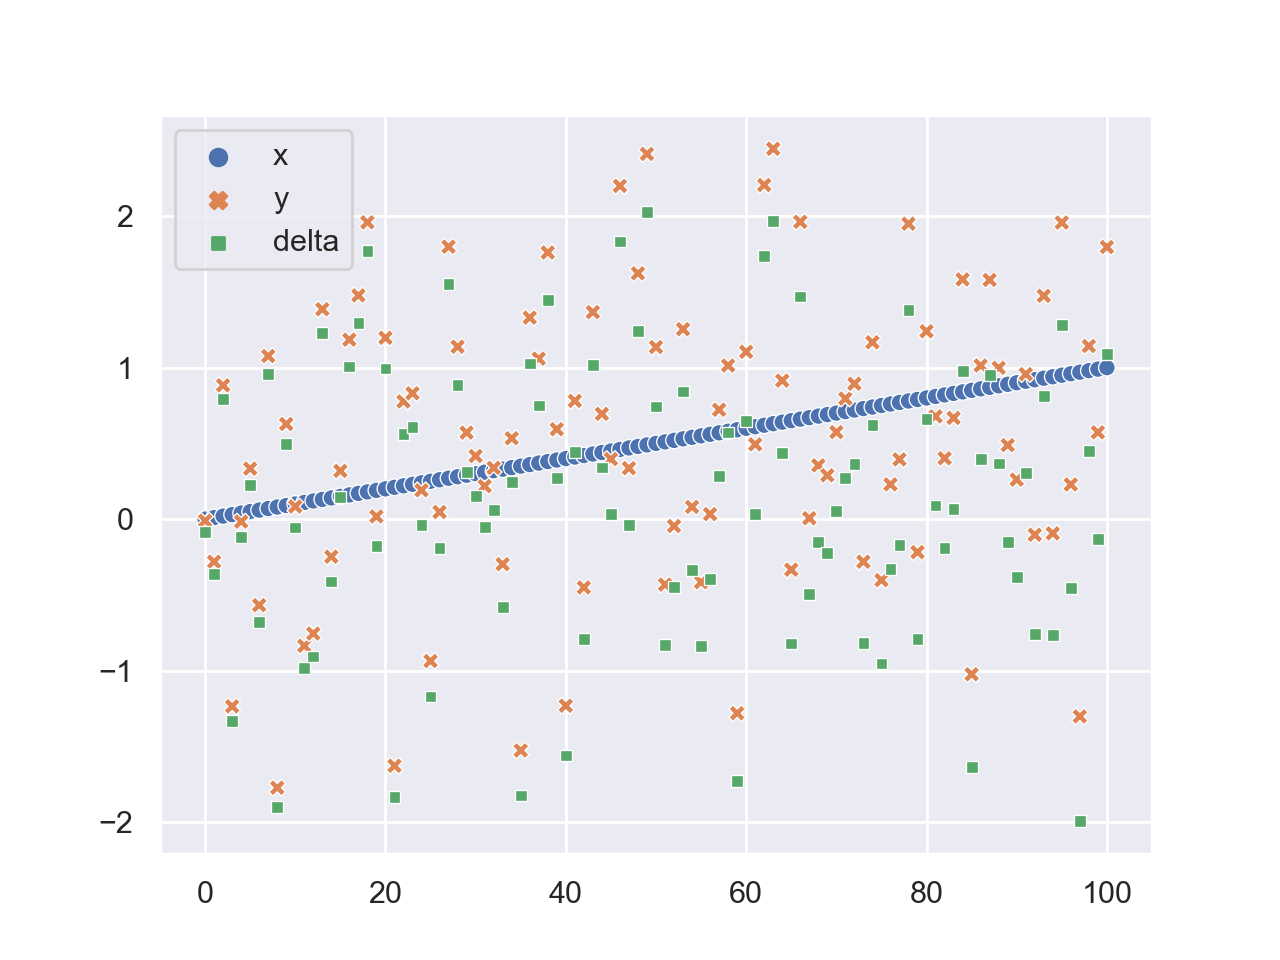

<AxesSubplot:>

In [26]:
noise = DataFrame({"x":X,"y":Y,"delta":delta})
sns.set_theme()
sns.scatterplot(data=noise)

Distribution of the noise is close to normal

<IPython.core.display.Javascript object>


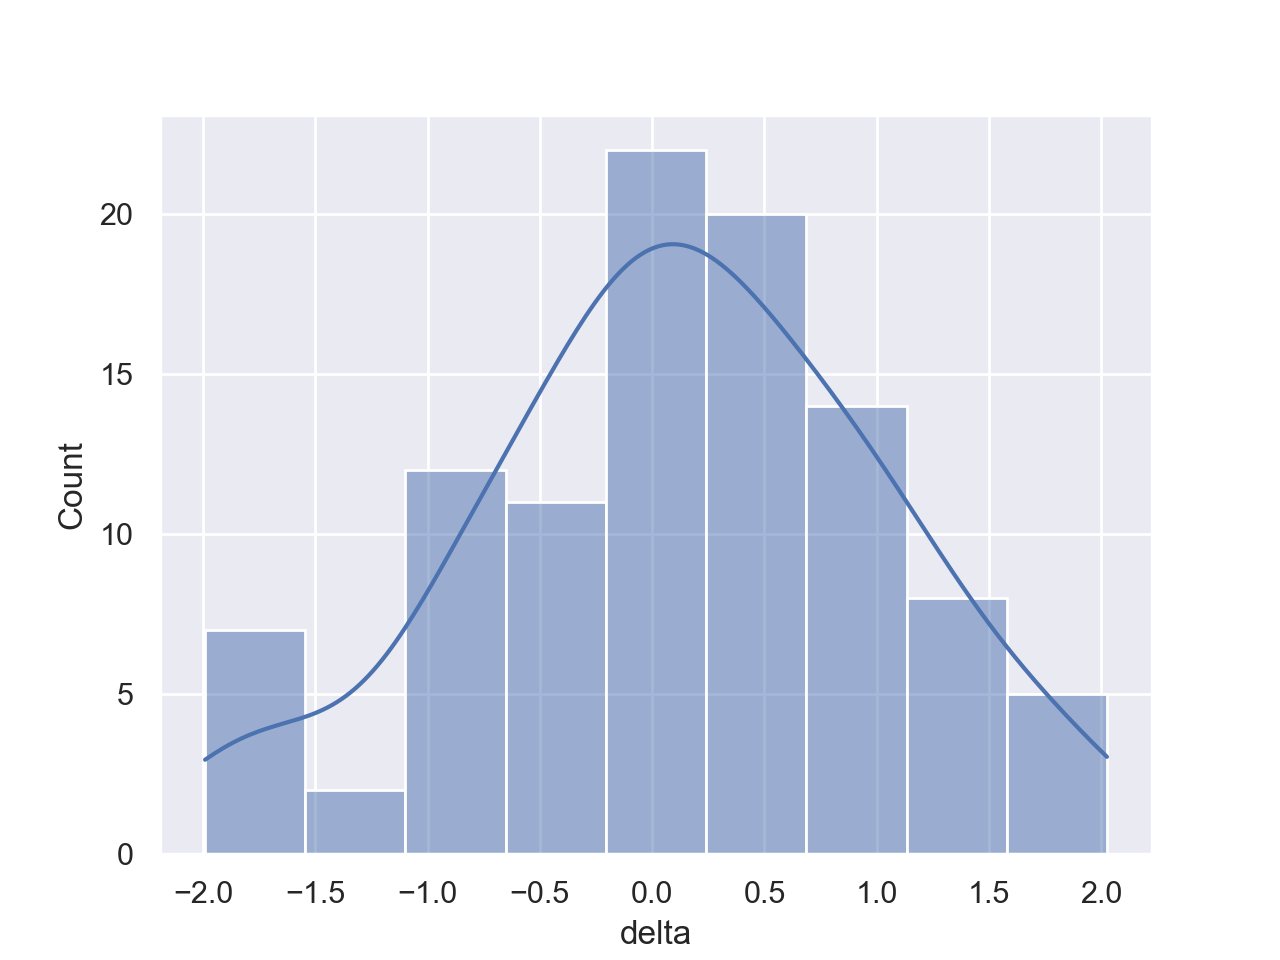

<AxesSubplot:xlabel='delta', ylabel='Count'>

In [27]:
sns.histplot(data=noise, x="delta", kde=True)

### Approximants
1. Linear approximant<br>$F(x,a,b)=a\times x + b$

In [9]:
linear_approximant = lambda x: x[1] * x[0] + x[2]# a * x + b

2. Rational approximant<br>$F(x,a,b)=\frac{a}{1+b\times x}$

In [10]:
rational_approximant = lambda x: x[1] / (1 + x[2] * x[0])# a / (1 + b * x)

#### Least squares

In [37]:
least_squares = lambda function, a, b: \
    sum([math.pow(function([x_k, a, b]) - y_k, 2) for x_k, y_k in zip(X, Y)])

### Minimisation funcions
Gradient descent

In [11]:
def gradient_descent(function, bounds):
    calls, iterations = 0,0
    beta_0 = EPSILON * 2
    
    f = lambda x, y: least_squares(x, y)
    
    def grad(a_n):
        points = np.arange(a_n - GRADIENT_STEP * 2, a_n + GRADIENT_STEP * 2.1, GRADIENT_STEP)
        values = [f(*point) for point in points]
        calls += len(pointsw)
        gradient = np.gradient(values, math.sqrt(0GRADIENT_STEP2 * 0GRADIENT_STEP2 * 2))
        return gradient[2]
    
    def beta(a_n, a_n_1, grad_a_n, grad_a_n_1):
        return abs((a_n - a_n_1) * (grad_a_n - grad_a_n_1)) \
            / np.linalg.norm(grad_a_n - grad_a_n_1) ** 2
    
    def next_point(a_n, a_n_1, grad_a_n_1):
        grad_a_n = grad(a_n)
        return a_n - beta(a_n, a_n_1, grad_a_n, grad_a_n_1) * grad_a_n
    
    def diff_magn(x1, x2):
        
    
    # setup initial approximation
    previous_x = [np.random.choice(np.arange(bound[0], bound[1], step=EPSILON)) for bound in bounds]
    previous_grad = grad(previous_x)
    current_x = previous_x - beta_0 * previous_grad
    

0.001

32.00000000000001